## Differential Equation:
$$\frac{d^4y}{dx^4} = -\frac{w x}{EI}$$

## Boundary Conditions:
$$y(0) = 0,\quad y(L) = 0,\quad \left.\frac{d^2y}{dx^2}\right|_{x=0} = 0,\quad \left.\frac{d^2y}{dx^2}\right|_{x=L} = 0$$

## Analytical Solution:
$$y(x) = \frac{w}{24EI}(-x^4 + 2Lx^3 - L^3x)$$

# 1. Setup

In [1]:
# Importing necessary libraries:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.optimize import minimize
print(tf.__version__)

2.18.0


In [2]:
# Defining constants
I = 0.000038929334 # Moment of inertia
E = 200 * 1e9 # Modulus of elasticity
w = 60000
L = 2.7 # Length of rod

# 2. Creating Model

In [3]:
class PINN(tf.keras.Model):
    def __init__(self, layers):
        # initialize the layers
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(layer, activation='sigmoid') for layer in layers]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)
        self.built = False

    def build(self, input_shape):
        # manually build each layer
        for layer in self.hidden_layers:
            layer.build(input_shape)
            input_shape = (input_shape[0], layer.units)
        self.output_layer.build(input_shape)
        super(PINN, self).build(input_shape)

    def call(self, x):
        if not self.built: 
            self.build(x.shape) # Build the model with the input shape 
            self.built = True
        # forward pass through the network
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# define the model
model = PINN(layers = [10, 7])

# 3. Loss Function

In [4]:
def second_derivative(model, x):
    with tf.GradientTape(persistent=True) as gg:
        gg.watch(x)
        with tf.GradientTape() as g:
            g.watch(x)
            y = model(x)
        y_x = g.gradient(y, x)
    y_xx = gg.gradient(y_x, x)
    return y_xx

def loss(model, x):
    with tf.GradientTape(persistent=True) as g4:
        g4.watch(x)
        with tf.GradientTape(persistent=True) as g3:
            g3.watch(x)
            with tf.GradientTape(persistent=True) as g2:
                g2.watch(x)
                with tf.GradientTape(persistent=True) as g1:
                    g1.watch(x)
                    y = model(x)
                dy_dx = g1.gradient(y,x)
            d2y_dx2 = g2.gradient(dy_dx,x)
        d3y_dx3 = g3.gradient(d2y_dx2,x)
    d4y_dx4 = g4.gradient(d3y_dx3,x)

    # DE residual
    residual = d4y_dx4 + ((w * x) / (E * I))
    residual = tf.reduce_mean(tf.square(residual))
    tf.print("residual=", residual)

    x_0 = tf.zeros((1,1))
    x_L = tf.constant([[L]])
    # BC1
    y_at_0 = model(x_0)
    # BC2
    y_at_L = model(x_L)
    # BC3&4
    y_xx_at_0 = second_derivative(model, x_0)
    y_xx_at_L = second_derivative(model, x_L)

    tf.print("y(0)=", y_at_0, ", y(L)=", y_at_L, ", y_xx(0)=", y_xx_at_0, ", y_xx(L)=", y_xx_at_L)

    boundary_loss = tf.reduce_mean(tf.square(y_at_0)) + tf.reduce_mean(tf.square(y_at_L)) + tf.reduce_mean(tf.square(y_xx_at_0)) + tf.reduce_mean(tf.square(y_xx_at_L))

    return residual + boundary_loss

## 4. Training the Model

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(model, x):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x)
    gradients = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return current_loss

loss_history = [] # Initialize a list to store the loss at each epoch 

# Training model and storing loss
epochs = 2000
# x = tf.linspace(0.0, L, 100)[:, None]
for epoch in range(epochs):
    x = np.random.normal(loc=(L/2), scale=0.1, size=100) # Generate 100 random points 
    x_tensor = tf.constant(x, dtype=tf.float32) 
    x_tensor = tf.expand_dims(x_tensor, axis=-1) # Ensure x_tensor is 2D
    current_loss = train_step(model, x_tensor)
    loss_history.append(current_loss.numpy())
    # if (epoch%100==0):
        # print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")
    # if (epoch == 999):
    #     print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")
    print(f"Epoch {epoch}: Loss = {current_loss.numpy()}")

residual= 9.39870879e-05
y(0)= [[-0.157993153]] , y(L)= [[-0.16493246]] , y_xx(0)= [[-0.000128314394]] , y_xx(L)= [[0.000809531717]]
Epoch 0: Loss = 0.052259210497140884
residual= 9.37036311e-05
y(0)= [[-0.151003912]] , y(L)= [[-0.158145666]] , y_xx(0)= [[-0.000138665971]] , y_xx(L)= [[0.000834764913]]
Epoch 1: Loss = 0.047906652092933655
residual= 9.43006598e-05
y(0)= [[-0.144016579]] , y(L)= [[-0.151362047]] , y_xx(0)= [[-0.000149031883]] , y_xx(L)= [[0.000859967724]]
Epoch 2: Loss = 0.043746307492256165
residual= 9.15049823e-05
y(0)= [[-0.137038127]] , y(L)= [[-0.144588307]] , y_xx(0)= [[-0.000159399337]] , y_xx(L)= [[0.000885112269]]
Epoch 3: Loss = 0.03977753594517708
residual= 9.43868072e-05
y(0)= [[-0.13007611]] , y(L)= [[-0.137831688]] , y_xx(0)= [[-0.000169756822]] , y_xx(L)= [[0.000910164206]]
Epoch 4: Loss = 0.03601261228322983
residual= 9.29639791e-05
y(0)= [[-0.123138398]] , y(L)= [[-0.131100014]] , y_xx(0)= [[-0.000180093164]] , y_xx(L)= [[0.000935091521]]
Epoch 5: Loss =

y(0)= [[0.0187471621]] , y(L)= [[0.00722885691]] , y_xx(0)= [[-0.000387610402]] , y_xx(L)= [[0.00134771597]]
Epoch 48: Loss = 0.000496315595228225
residual= 9.18614e-05
y(0)= [[0.0177930929]] , y(L)= [[0.00635665655]] , y_xx(0)= [[-0.000385673193]] , y_xx(L)= [[0.00134039007]]
Epoch 49: Loss = 0.0004508080310188234
residual= 9.31069e-05
y(0)= [[0.0167896952]] , y(L)= [[0.00543724559]] , y_xx(0)= [[-0.000383659906]] , y_xx(L)= [[0.00133286056]]
Epoch 50: Loss = 0.0004064881650265306
residual= 9.21572e-05
y(0)= [[0.0157512538]] , y(L)= [[0.00448421575]] , y_xx(0)= [[-0.00038159336]] , y_xx(L)= [[0.00132517738]]
Epoch 51: Loss = 0.00036226908559910953
residual= 9.17298239e-05
y(0)= [[0.0146909738]] , y(L)= [[0.00351044908]] , y_xx(0)= [[-0.000379494246]] , y_xx(L)= [[0.00131739012]]
Epoch 52: Loss = 0.0003217573103029281
residual= 9.16949211e-05
y(0)= [[0.013621618]] , y(L)= [[0.00252809562]] , y_xx(0)= [[-0.0003773848]] , y_xx(L)= [[0.00130954466]]
Epoch 53: Loss = 0.00028549195849336684

Epoch 95: Loss = 0.0001346694043604657
residual= 9.40434911e-05
y(0)= [[0.00483741425]] , y(L)= [[-0.00383117981]] , y_xx(0)= [[-0.000347097201]] , y_xx(L)= [[0.00109575549]]
Epoch 96: Loss = 0.00013344315811991692
residual= 9.47398657e-05
y(0)= [[0.00488856435]] , y(L)= [[-0.00373263098]] , y_xx(0)= [[-0.00034680948]] , y_xx(L)= [[0.00109167991]]
Epoch 97: Loss = 0.0001338824804406613
residual= 9.57508601e-05
y(0)= [[0.00492240302]] , y(L)= [[-0.00365084037]] , y_xx(0)= [[-0.000346495799]] , y_xx(L)= [[0.00108754786]]
Epoch 98: Loss = 0.0001346123608527705
residual= 9.7164746e-05
y(0)= [[0.00493949093]] , y(L)= [[-0.00358515419]] , y_xx(0)= [[-0.000346154906]] , y_xx(L)= [[0.00108336413]]
Epoch 99: Loss = 0.0001357101573375985
residual= 9.55011637e-05
y(0)= [[0.00494087487]] , y(L)= [[-0.00353468768]] , y_xx(0)= [[-0.000345793407]] , y_xx(L)= [[0.00107913103]]
Epoch 100: Loss = 0.00013369151565711945
residual= 9.3490773e-05
y(0)= [[0.00492750295]] , y(L)= [[-0.00349846296]] , y_xx(0)=

Epoch 142: Loss = 0.00011826571426354349
residual= 9.64509309e-05
y(0)= [[0.00314087607]] , y(L)= [[-0.0032491833]] , y_xx(0)= [[-0.000328277209]] , y_xx(L)= [[0.00090191135]]
Epoch 143: Loss = 0.00011779442866099998
residual= 9.6669326e-05
y(0)= [[0.00313138403]] , y(L)= [[-0.00321462192]] , y_xx(0)= [[-0.000327947579]] , y_xx(L)= [[0.000898260158]]
Epoch 144: Loss = 0.00011772311700042337
residual= 9.66522348e-05
y(0)= [[0.00312047079]] , y(L)= [[-0.00318162329]] , y_xx(0)= [[-0.000327618036]] , y_xx(L)= [[0.000894623343]]
Epoch 145: Loss = 0.00011741998605430126
residual= 9.52188129e-05
y(0)= [[0.00310804509]] , y(L)= [[-0.00315021724]] , y_xx(0)= [[-0.000327287766]] , y_xx(L)= [[0.000891000149]]
Epoch 146: Loss = 0.00011570362403290346
residual= 9.16530189e-05
y(0)= [[0.00309408456]] , y(L)= [[-0.00312046707]] , y_xx(0)= [[-0.000326955807]] , y_xx(L)= [[0.00088739011]]
Epoch 147: Loss = 0.00011185805487912148
residual= 9.33841875e-05
y(0)= [[0.00307864323]] , y(L)= [[-0.00309233367

y(0)= [[0.00223343447]] , y(L)= [[-0.00231479108]] , y_xx(0)= [[-0.000313885277]] , y_xx(L)= [[0.00075348746]]
Epoch 189: Loss = 0.00010597000073175877
residual= 9.67137676e-05
y(0)= [[0.00221748836]] , y(L)= [[-0.00229573622]] , y_xx(0)= [[-0.000313610944]] , y_xx(L)= [[0.000750775682]]
Epoch 190: Loss = 0.00010756343544926494
residual= 9.68718741e-05
y(0)= [[0.00220148079]] , y(L)= [[-0.00227697194]] , y_xx(0)= [[-0.0003133383]] , y_xx(L)= [[0.000748087943]]
Epoch 191: Loss = 0.00010756080882856622
residual= 9.64289648e-05
y(0)= [[0.00218545273]] , y(L)= [[-0.00225840881]] , y_xx(0)= [[-0.000313067052]] , y_xx(L)= [[0.000745423604]]
Epoch 192: Loss = 0.00010695924720494077
residual= 9.66679509e-05
y(0)= [[0.00216933154]] , y(L)= [[-0.00224016234]] , y_xx(0)= [[-0.00031279691]] , y_xx(L)= [[0.000742780161]]
Epoch 193: Loss = 0.00010704184387577698
residual= 9.47260196e-05
y(0)= [[0.00215321593]] , y(L)= [[-0.0022221785]] , y_xx(0)= [[-0.000312527496]] , y_xx(L)= [[0.000740159652]]
Epo

Epoch 235: Loss = 0.00010201226541539654
residual= 9.4642186e-05
y(0)= [[0.00154229254]] , y(L)= [[-0.00159513764]] , y_xx(0)= [[-0.000302518689]] , y_xx(L)= [[0.000650012807]]
Epoch 236: Loss = 0.00010007934179157019
residual= 9.50808535e-05
y(0)= [[0.00153007731]] , y(L)= [[-0.00158236921]] , y_xx(0)= [[-0.000302310073]] , y_xx(L)= [[0.000648326939]]
Epoch 237: Loss = 0.00010043759539257735
residual= 9.49862e-05
y(0)= [[0.00151797384]] , y(L)= [[-0.00156977586]] , y_xx(0)= [[-0.000302101689]] , y_xx(L)= [[0.000646661036]]
Epoch 238: Loss = 0.0001002640783553943
residual= 9.70739129e-05
y(0)= [[0.00150601752]] , y(L)= [[-0.00155719]] , y_xx(0)= [[-0.000301895547]] , y_xx(L)= [[0.000645015039]]
Epoch 239: Loss = 0.00010227403254248202
residual= 9.86479427e-05
y(0)= [[0.001494091]] , y(L)= [[-0.00154479407]] , y_xx(0)= [[-0.000301689317]] , y_xx(L)= [[0.000643389707]]
Epoch 240: Loss = 0.00010377160651842132
residual= 9.53353883e-05
y(0)= [[0.00148223154]] , y(L)= [[-0.00153251924]] , y

Epoch 282: Loss = 0.00010200100223300979
residual= 9.7868804e-05
y(0)= [[0.00106919]] , y(L)= [[-0.00110364705]] , y_xx(0)= [[-0.000293978694]] , y_xx(L)= [[0.000591927266]]
Epoch 283: Loss = 0.00010066681716125458
residual= 9.52510891e-05
y(0)= [[0.00106118992]] , y(L)= [[-0.0010953974]] , y_xx(0)= [[-0.000293822726]] , y_xx(L)= [[0.000591127435]]
Epoch 284: Loss = 9.80128679657355e-05
residual= 9.3872768e-05
y(0)= [[0.00105330534]] , y(L)= [[-0.00108715706]] , y_xx(0)= [[-0.000293666963]] , y_xx(L)= [[0.000590340293]]
Epoch 285: Loss = 9.659888019086793e-05
residual= 0.000100899342
y(0)= [[0.00104544498]] , y(L)= [[-0.001079062]] , y_xx(0)= [[-0.000293512625]] , y_xx(L)= [[0.000589566538]]
Epoch 286: Loss = 0.0001035904060699977
residual= 9.8737677e-05
y(0)= [[0.00103768334]] , y(L)= [[-0.00107097812]] , y_xx(0)= [[-0.000293357414]] , y_xx(L)= [[0.000588812516]]
Epoch 287: Loss = 0.00010139421647181734
residual= 9.48640591e-05
y(0)= [[0.00103002414]] , y(L)= [[-0.00106302463]] , y_xx

y(0)= [[0.000775041059]] , y(L)= [[-0.000797603279]] , y_xx(0)= [[-0.000287628674]] , y_xx(L)= [[0.000570408476]]
Epoch 329: Loss = 9.904453327180818e-05
residual= 9.87260792e-05
y(0)= [[0.000770123675]] , y(L)= [[-0.000792516395]] , y_xx(0)= [[-0.000287507311]] , y_xx(L)= [[0.000570258882]]
Epoch 330: Loss = 0.00010035510786110535
residual= 9.71971385e-05
y(0)= [[0.000765319914]] , y(L)= [[-0.00078747794]] , y_xx(0)= [[-0.000287387]] , y_xx(L)= [[0.000570122269]]
Epoch 331: Loss = 9.881060395855457e-05
residual= 9.82342463e-05
y(0)= [[0.000760512426]] , y(L)= [[-0.000782493502]] , y_xx(0)= [[-0.000287266215]] , y_xx(L)= [[0.000569997646]]
Epoch 332: Loss = 9.98323448584415e-05
residual= 9.65941508e-05
y(0)= [[0.000755813]] , y(L)= [[-0.000777522102]] , y_xx(0)= [[-0.000287147763]] , y_xx(L)= [[0.000569884665]]
Epoch 333: Loss = 9.817715908866376e-05
residual= 9.35297867e-05
y(0)= [[0.000751091167]] , y(L)= [[-0.000772651285]] , y_xx(0)= [[-0.000287028961]] , y_xx(L)= [[0.000569782453]

Epoch 375: Loss = 9.766015864443034e-05
residual= 9.62129125e-05
y(0)= [[0.000596538186]] , y(L)= [[-0.000611802563]] , y_xx(0)= [[-0.000282487774]] , y_xx(L)= [[0.000574753329]]
Epoch 376: Loss = 9.735322237247601e-05
residual= 9.78972821e-05
y(0)= [[0.000593734905]] , y(L)= [[-0.00060890615]] , y_xx(0)= [[-0.000282388763]] , y_xx(L)= [[0.000575067126]]
Epoch 377: Loss = 9.903101454256102e-05
residual= 9.6213771e-05
y(0)= [[0.000590993091]] , y(L)= [[-0.00060598366]] , y_xx(0)= [[-0.000282290479]] , y_xx(L)= [[0.000575392332]]
Epoch 378: Loss = 9.734102786751464e-05
residual= 9.59072422e-05
y(0)= [[0.000588307157]] , y(L)= [[-0.000603156164]] , y_xx(0)= [[-0.00028219365]] , y_xx(L)= [[0.000575725164]]
Epoch 379: Loss = 9.70282344496809e-05
residual= 9.94446236e-05
y(0)= [[0.000585598871]] , y(L)= [[-0.000600351]] , y_xx(0)= [[-0.000282094668]] , y_xx(L)= [[0.000576065388]]
Epoch 380: Loss = 0.00010055939492303878
residual= 9.6486845e-05
y(0)= [[0.000582963228]] , y(L)= [[-0.000597585]

y(0)= [[0.000499688089]] , y(L)= [[-0.000510811806]] , y_xx(0)= [[-0.000278270629]] , y_xx(L)= [[0.000596778467]]
Epoch 422: Loss = 9.66700172284618e-05
residual= 9.37536388e-05
y(0)= [[0.000498190522]] , y(L)= [[-0.000509196892]] , y_xx(0)= [[-0.000278185646]] , y_xx(L)= [[0.000597401639]]
Epoch 423: Loss = 9.469538053963333e-05
residual= 9.54824864e-05
y(0)= [[0.000496700406]] , y(L)= [[-0.000507604331]] , y_xx(0)= [[-0.000278098392]] , y_xx(L)= [[0.00059802836]]
Epoch 424: Loss = 9.6421834314242e-05
residual= 9.65320796e-05
y(0)= [[0.000495249406]] , y(L)= [[-0.000506065786]] , y_xx(0)= [[-0.000278013205]] , y_xx(L)= [[0.000598661485]]
Epoch 425: Loss = 9.746914292918518e-05
residual= 9.58951277e-05
y(0)= [[0.000493787229]] , y(L)= [[-0.000504570082]] , y_xx(0)= [[-0.000277927786]] , y_xx(L)= [[0.000599302235]]
Epoch 426: Loss = 9.682995005277917e-05
residual= 9.49424721e-05
y(0)= [[0.000492362306]] , y(L)= [[-0.000503065065]] , y_xx(0)= [[-0.00027784353]] , y_xx(L)= [[0.00059994653

Epoch 468: Loss = 9.396687528351322e-05
residual= 9.66121661e-05
y(0)= [[0.000448124483]] , y(L)= [[-0.000456653535]] , y_xx(0)= [[-0.000274415361]] , y_xx(L)= [[0.000631273433]]
Epoch 469: Loss = 9.749532182468101e-05
residual= 9.24038686e-05
y(0)= [[0.000447297469]] , y(L)= [[-0.000455897301]] , y_xx(0)= [[-0.000274335034]] , y_xx(L)= [[0.000632103533]]
Epoch 470: Loss = 9.328660235041752e-05
residual= 9.43977502e-05
y(0)= [[0.000446513295]] , y(L)= [[-0.000455157831]] , y_xx(0)= [[-0.000274256134]] , y_xx(L)= [[0.000632935204]]
Epoch 471: Loss = 9.52801201492548e-05
residual= 9.1059308e-05
y(0)= [[0.00044571422]] , y(L)= [[-0.000454418361]] , y_xx(0)= [[-0.000274175603]] , y_xx(L)= [[0.000633771357]]
Epoch 472: Loss = 9.194131416734308e-05
residual= 9.25038912e-05
y(0)= [[0.000444978476]] , y(L)= [[-0.000453645363]] , y_xx(0)= [[-0.000274096441]] , y_xx(L)= [[0.000634606055]]
Epoch 473: Loss = 9.33855480980128e-05
residual= 9.22126783e-05
y(0)= [[0.000444186851]] , y(L)= [[-0.000452

y(0)= [[0.000423178077]] , y(L)= [[-0.000430589542]] , y_xx(0)= [[-0.000270855206]] , y_xx(L)= [[0.000672829919]]
Epoch 515: Loss = 9.393436630489305e-05
residual= 9.28744921e-05
y(0)= [[0.000422876328]] , y(L)= [[-0.00043017976]] , y_xx(0)= [[-0.000270780321]] , y_xx(L)= [[0.000673801522]]
Epoch 516: Loss = 9.376569505548105e-05
residual= 9.44216372e-05
y(0)= [[0.000422529876]] , y(L)= [[-0.000429831445]] , y_xx(0)= [[-0.000270704506]] , y_xx(L)= [[0.000674773939]]
Epoch 517: Loss = 9.531353134661913e-05
residual= 9.24658525e-05
y(0)= [[0.000422205776]] , y(L)= [[-0.00042944029]] , y_xx(0)= [[-0.000270629331]] , y_xx(L)= [[0.000675751362]]
Epoch 518: Loss = 9.33584087761119e-05
residual= 9.18343503e-05
y(0)= [[0.000421891]] , y(L)= [[-0.000429073349]] , y_xx(0)= [[-0.000270551944]] , y_xx(L)= [[0.000676730531]]
Epoch 519: Loss = 9.272760507883504e-05
residual= 9.42811821e-05
y(0)= [[0.000421591103]] , y(L)= [[-0.000428682193]] , y_xx(0)= [[-0.000270477292]] , y_xx(L)= [[0.00067771069]

Epoch 561: Loss = 9.402584691997617e-05
residual= 9.28077279e-05
y(0)= [[0.000412616879]] , y(L)= [[-0.000418918207]] , y_xx(0)= [[-0.000267364579]] , y_xx(L)= [[0.00072120456]]
Epoch 562: Loss = 9.374509681947529e-05
residual= 9.3135408e-05
y(0)= [[0.000412387773]] , y(L)= [[-0.000418733805]] , y_xx(0)= [[-0.00026729]] , y_xx(L)= [[0.000722280121]]
Epoch 563: Loss = 9.407393372384831e-05
residual= 9.0738562e-05
y(0)= [[0.000412305817]] , y(L)= [[-0.000418582931]] , y_xx(0)= [[-0.000267216703]] , y_xx(L)= [[0.000723360339]]
Epoch 564: Loss = 9.167842654278502e-05
residual= 9.1547241e-05
y(0)= [[0.000412112102]] , y(L)= [[-0.000418465585]] , y_xx(0)= [[-0.000267141964]] , y_xx(L)= [[0.000724439276]]
Epoch 565: Loss = 9.248836431652308e-05
residual= 8.9405039e-05
y(0)= [[0.000411951914]] , y(L)= [[-0.000418337062]] , y_xx(0)= [[-0.000267068273]] , y_xx(L)= [[0.000725518912]]
Epoch 566: Loss = 9.034745744429529e-05
residual= 9.32924086e-05
y(0)= [[0.000411761925]] , y(L)= [[-0.00041815824

y(0)= [[0.000407388434]] , y(L)= [[-0.00041309]] , y_xx(0)= [[-0.000263958471]] , y_xx(L)= [[0.000772378291]]
Epoch 608: Loss = 9.312705515185371e-05
residual= 8.80843218e-05
y(0)= [[0.000407306477]] , y(L)= [[-0.000413056463]] , y_xx(0)= [[-0.00026388446]] , y_xx(L)= [[0.000773536158]]
Epoch 609: Loss = 8.908883319236338e-05
residual= 9.05509223e-05
y(0)= [[0.000407254323]] , y(L)= [[-0.000412946567]] , y_xx(0)= [[-0.000263811788]] , y_xx(L)= [[0.000774688087]]
Epoch 610: Loss = 9.15570417419076e-05
residual= 8.71086595e-05
y(0)= [[0.000407170504]] , y(L)= [[-0.00041285716]] , y_xx(0)= [[-0.000263738184]] , y_xx(L)= [[0.000775843568]]
Epoch 611: Loss = 8.811639418127015e-05
residual= 8.86142661e-05
y(0)= [[0.000407056883]] , y(L)= [[-0.00041276589]] , y_xx(0)= [[-0.000263663387]] , y_xx(L)= [[0.000776996836]]
Epoch 612: Loss = 8.962357969721779e-05
residual= 9.0429e-05
y(0)= [[0.000406945124]] , y(L)= [[-0.000412713736]] , y_xx(0)= [[-0.000263589376]] , y_xx(L)= [[0.000778148416]]
Epo

Epoch 654: Loss = 9.317055810242891e-05
residual= 9.02777538e-05
y(0)= [[0.000405183062]] , y(L)= [[-0.000410344452]] , y_xx(0)= [[-0.000260520814]] , y_xx(L)= [[0.000828158]]
Epoch 655: Loss = 9.136402513831854e-05
residual= 9.02344e-05
y(0)= [[0.000405186787]] , y(L)= [[-0.00041028671]] , y_xx(0)= [[-0.000260449044]] , y_xx(L)= [[0.000829386932]]
Epoch 656: Loss = 9.132263221545145e-05
residual= 9.11031093e-05
y(0)= [[0.000405197963]] , y(L)= [[-0.000410225242]] , y_xx(0)= [[-0.00026037838]] , y_xx(L)= [[0.000830618432]]
Epoch 657: Loss = 9.21933024073951e-05
residual= 8.6769e-05
y(0)= [[0.000405283645]] , y(L)= [[-0.000410201028]] , y_xx(0)= [[-0.000260308268]] , y_xx(L)= [[0.000831855]]
Epoch 658: Loss = 8.786126272752881e-05
residual= 8.83541361e-05
y(0)= [[0.000405283645]] , y(L)= [[-0.00041016005]] , y_xx(0)= [[-0.000260236149]] , y_xx(L)= [[0.000833088125]]
Epoch 659: Loss = 8.944838918978348e-05
residual= 8.93791366e-05
y(0)= [[0.000405300409]] , y(L)= [[-0.000410148874]] , y_

y(0)= [[0.00040428713]] , y(L)= [[-0.000408884138]] , y_xx(0)= [[-0.000257230655]] , y_xx(L)= [[0.000885788584]]
Epoch 701: Loss = 8.776571485213935e-05
residual= 8.84361361e-05
y(0)= [[0.000404262915]] , y(L)= [[-0.00040887855]] , y_xx(0)= [[-0.000257158768]] , y_xx(L)= [[0.00088707346]]
Epoch 702: Loss = 8.961977437138557e-05
residual= 8.63587047e-05
y(0)= [[0.000404275954]] , y(L)= [[-0.000408833846]] , y_xx(0)= [[-0.000257088745]] , y_xx(L)= [[0.000888362643]]
Epoch 703: Loss = 8.754456939641386e-05
residual= 8.50638e-05
y(0)= [[0.000404270366]] , y(L)= [[-0.000408830121]] , y_xx(0)= [[-0.000257018139]] , y_xx(L)= [[0.000889652176]]
Epoch 704: Loss = 8.625191549072042e-05
residual= 8.68629722e-05
y(0)= [[0.00040428713]] , y(L)= [[-0.000408757478]] , y_xx(0)= [[-0.000256947882]] , y_xx(L)= [[0.000890940079]]
Epoch 705: Loss = 8.805330435279757e-05
residual= 8.50208671e-05
y(0)= [[0.000404296443]] , y(L)= [[-0.000408740714]] , y_xx(0)= [[-0.000256878673]] , y_xx(L)= [[0.000892230717]

Epoch 747: Loss = 8.623589383205399e-05
residual= 8.66042756e-05
y(0)= [[0.000404499471]] , y(L)= [[-0.000408135355]] , y_xx(0)= [[-0.000254012761]] , y_xx(L)= [[0.000947621826]]
Epoch 748: Loss = 8.789698040345684e-05
residual= 8.33325903e-05
y(0)= [[0.000404505059]] , y(L)= [[-0.00040817447]] , y_xx(0)= [[-0.000253947946]] , y_xx(L)= [[0.000948970264]]
Epoch 749: Loss = 8.462784899165854e-05
residual= 8.54915779e-05
y(0)= [[0.000404488295]] , y(L)= [[-0.00040817447]] , y_xx(0)= [[-0.000253882376]] , y_xx(L)= [[0.000950318761]]
Epoch 750: Loss = 8.678935409989208e-05
residual= 8.30404824e-05
y(0)= [[0.000404510647]] , y(L)= [[-0.000408140942]] , y_xx(0)= [[-0.000253815815]] , y_xx(L)= [[0.000951667898]]
Epoch 751: Loss = 8.434078335994855e-05
residual= 8.18200133e-05
y(0)= [[0.000404486433]] , y(L)= [[-0.000408178195]] , y_xx(0)= [[-0.000253750826]] , y_xx(L)= [[0.000953016]]
Epoch 752: Loss = 8.312286081491038e-05
residual= 8.48997443e-05
y(0)= [[0.000404439867]] , y(L)= [[-0.0004081

y(0)= [[0.000403828919]] , y(L)= [[-0.000406717882]] , y_xx(0)= [[-0.000251022051]] , y_xx(L)= [[0.00101043994]]
Epoch 794: Loss = 8.352031727554277e-05
residual= 8.27463737e-05
y(0)= [[0.00040378049]] , y(L)= [[-0.000406723469]] , y_xx(0)= [[-0.000250959652]] , y_xx(L)= [[0.00101183262]]
Epoch 795: Loss = 8.416162745561451e-05
residual= 8.11824211e-05
y(0)= [[0.00040376]] , y(L)= [[-0.000406688079]] , y_xx(0)= [[-0.000250899146]] , y_xx(L)= [[0.00101322797]]
Epoch 796: Loss = 8.260042523033917e-05
residual= 8.12201761e-05
y(0)= [[0.000403705984]] , y(L)= [[-0.000406710431]] , y_xx(0)= [[-0.000250836689]] , y_xx(L)= [[0.00101462402]]
Epoch 797: Loss = 8.264095231425017e-05
residual= 8.24065864e-05
y(0)= [[0.000403713435]] , y(L)= [[-0.000406693667]] , y_xx(0)= [[-0.000250775134]] , y_xx(L)= [[0.00101602031]]
Epoch 798: Loss = 8.383014937862754e-05
residual= 8.06350654e-05
y(0)= [[0.000403655693]] , y(L)= [[-0.000406701118]] , y_xx(0)= [[-0.0002507139]] , y_xx(L)= [[0.00101741799]]
Epoc

Epoch 840: Loss = 8.278596942545846e-05
residual= 7.92449791e-05
y(0)= [[0.000404179096]] , y(L)= [[-0.000405803323]] , y_xx(0)= [[-0.000248309749]] , y_xx(L)= [[0.00107720774]]
Epoch 841: Loss = 8.079504914348945e-05
residual= 7.76409506e-05
y(0)= [[0.000404242426]] , y(L)= [[-0.000405775383]] , y_xx(0)= [[-0.000248257973]] , y_xx(L)= [[0.00107865548]]
Epoch 842: Loss = 7.919414929347113e-05
residual= 8.03342846e-05
y(0)= [[0.000404274091]] , y(L)= [[-0.000405777246]] , y_xx(0)= [[-0.000248204218]] , y_xx(L)= [[0.00108010054]]
Epoch 843: Loss = 8.189060463337228e-05
residual= 7.72542553e-05
y(0)= [[0.000404251739]] , y(L)= [[-0.000405723229]] , y_xx(0)= [[-0.000248152646]] , y_xx(L)= [[0.00108154654]]
Epoch 844: Loss = 7.88136021583341e-05
residual= 7.87723693e-05
y(0)= [[0.000404203311]] , y(L)= [[-0.000405736268]] , y_xx(0)= [[-0.000248098047]] , y_xx(L)= [[0.00108299032]]
Epoch 845: Loss = 8.033479389268905e-05
residual= 7.76042725e-05
y(0)= [[0.000404164195]] , y(L)= [[-0.00040571

y(0)= [[0.000404432416]] , y(L)= [[-0.000404926017]] , y_xx(0)= [[-0.000246099662]] , y_xx(L)= [[0.00114460394]]
Epoch 887: Loss = 8.089366019703448e-05
residual= 7.85517768e-05
y(0)= [[0.000404480845]] , y(L)= [[-0.0004050266]] , y_xx(0)= [[-0.000246060546]] , y_xx(L)= [[0.0011461043]]
Epoch 888: Loss = 8.025352872209623e-05
residual= 7.56010704e-05
y(0)= [[0.000404546037]] , y(L)= [[-0.000405041501]] , y_xx(0)= [[-0.000246023468]] , y_xx(L)= [[0.00114760769]]
Epoch 889: Loss = 7.730632205493748e-05
residual= 7.37787632e-05
y(0)= [[0.000404577702]] , y(L)= [[-0.000405086204]] , y_xx(0)= [[-0.000245985866]] , y_xx(L)= [[0.00114910793]]
Epoch 890: Loss = 7.548749272245914e-05
residual= 8.04127558e-05
y(0)= [[0.000404527411]] , y(L)= [[-0.000405173749]] , y_xx(0)= [[-0.000245945354]] , y_xx(L)= [[0.00115060131]]
Epoch 891: Loss = 8.212494140025228e-05
residual= 7.71442355e-05
y(0)= [[0.000404553488]] , y(L)= [[-0.000405225903]] , y_xx(0)= [[-0.000245908363]] , y_xx(L)= [[0.0011521026]]
E

Epoch 933: Loss = 7.399555761367083e-05
residual= 7.20216049e-05
y(0)= [[0.000405432656]] , y(L)= [[-0.000404870138]] , y_xx(0)= [[-0.000244591851]] , y_xx(L)= [[0.00121552218]]
Epoch 934: Loss = 7.388721860479563e-05
residual= 7.5675307e-05
y(0)= [[0.000405380502]] , y(L)= [[-0.000404825434]] , y_xx(0)= [[-0.000244565454]] , y_xx(L)= [[0.00121703115]]
Epoch 935: Loss = 7.754450780339539e-05
residual= 7.36132642e-05
y(0)= [[0.000405339524]] , y(L)= [[-0.000404797494]] , y_xx(0)= [[-0.000244539464]] , y_xx(L)= [[0.00121854676]]
Epoch 936: Loss = 7.548608118668199e-05
residual= 7.33428897e-05
y(0)= [[0.000405257568]] , y(L)= [[-0.000404767692]] , y_xx(0)= [[-0.000244515832]] , y_xx(L)= [[0.00122006109]]
Epoch 937: Loss = 7.521930092480034e-05
residual= 7.36964794e-05
y(0)= [[0.000405211]] , y(L)= [[-0.000404730439]] , y_xx(0)= [[-0.000244490715]] , y_xx(L)= [[0.0012215774]]
Epoch 938: Loss = 7.557650678791106e-05
residual= 7.46617952e-05
y(0)= [[0.000405227765]] , y(L)= [[-0.000404657796

y(0)= [[0.000403838232]] , y(L)= [[-0.000402212143]] , y_xx(0)= [[-0.000243822244]] , y_xx(L)= [[0.00128551316]]
Epoch 980: Loss = 7.377166912192479e-05
residual= 6.99242737e-05
y(0)= [[0.000403838232]] , y(L)= [[-0.000402184203]] , y_xx(0)= [[-0.000243817616]] , y_xx(L)= [[0.00128704752]]
Epoch 981: Loss = 7.196504157036543e-05
residual= 6.96606e-05
y(0)= [[0.000403840095]] , y(L)= [[-0.000402145088]] , y_xx(0)= [[-0.000243811664]] , y_xx(L)= [[0.00128858082]]
Epoch 982: Loss = 7.170528988353908e-05
residual= 7.18466399e-05
y(0)= [[0.000403828919]] , y(L)= [[-0.000402029604]] , y_xx(0)= [[-0.000243807852]] , y_xx(L)= [[0.00129011297]]
Epoch 983: Loss = 7.389517850242555e-05
residual= 7.01605459e-05
y(0)= [[0.000403821468]] , y(L)= [[-0.000401943922]] , y_xx(0)= [[-0.000243804956]] , y_xx(L)= [[0.00129165116]]
Epoch 984: Loss = 7.221296982606873e-05
residual= 7.09787128e-05
y(0)= [[0.000403881073]] , y(L)= [[-0.000401902944]] , y_xx(0)= [[-0.00024380305]] , y_xx(L)= [[0.00129318843]]
E

Epoch 1026: Loss = 6.950098759261891e-05
residual= 6.83871767e-05
y(0)= [[0.000403722748]] , y(L)= [[-0.000400522724]] , y_xx(0)= [[-0.000244287919]] , y_xx(L)= [[0.00135804585]]
Epoch 1027: Loss = 7.061455107759684e-05
residual= 6.69894e-05
y(0)= [[0.000403782353]] , y(L)= [[-0.000400457531]] , y_xx(0)= [[-0.000244315335]] , y_xx(L)= [[0.00135959708]]
Epoch 1028: Loss = 6.922100146766752e-05
residual= 6.70280133e-05
y(0)= [[0.000403827056]] , y(L)= [[-0.00040037185]] , y_xx(0)= [[-0.000244343362]] , y_xx(L)= [[0.00136114587]]
Epoch 1029: Loss = 6.926381320226938e-05
residual= 6.81810343e-05
y(0)= [[0.000403832644]] , y(L)= [[-0.000400312245]] , y_xx(0)= [[-0.000244372291]] , y_xx(L)= [[0.00136269676]]
Epoch 1030: Loss = 7.04210324329324e-05
residual= 6.8042049e-05
y(0)= [[0.000403925776]] , y(L)= [[-0.00040028058]] , y_xx(0)= [[-0.000244402618]] , y_xx(L)= [[0.0013642502]]
Epoch 1031: Loss = 7.028633990557864e-05
residual= 6.77604476e-05
y(0)= [[0.000403936952]] , y(L)= [[-0.000400237

y(0)= [[0.000402823091]] , y(L)= [[-0.000398252159]] , y_xx(0)= [[-0.00024630758]] , y_xx(L)= [[0.00142898283]]
Epoch 1073: Loss = 6.519641465274617e-05
residual= 6.28644775e-05
y(0)= [[0.000402720645]] , y(L)= [[-0.000398172066]] , y_xx(0)= [[-0.000246366952]] , y_xx(L)= [[0.00143050891]]
Epoch 1074: Loss = 6.52922535664402e-05
residual= 6.16790276e-05
y(0)= [[0.000402728096]] , y(L)= [[-0.000398036093]] , y_xx(0)= [[-0.000246429874]] , y_xx(L)= [[0.0014320343]]
Epoch 1075: Loss = 6.41110964352265e-05
residual= 6.22023435e-05
y(0)= [[0.000402605161]] , y(L)= [[-0.000397954136]] , y_xx(0)= [[-0.000246490497]] , y_xx(L)= [[0.00143355539]]
Epoch 1076: Loss = 6.463863974204287e-05
residual= 6.34184617e-05
y(0)= [[0.000402489677]] , y(L)= [[-0.000397851691]] , y_xx(0)= [[-0.000246553536]] , y_xx(L)= [[0.00143507496]]
Epoch 1077: Loss = 6.585897790500894e-05
residual= 6.27419577e-05
y(0)= [[0.000402450562]] , y(L)= [[-0.000397719443]] , y_xx(0)= [[-0.000246617477]] , y_xx(L)= [[0.0014365958

Epoch 1119: Loss = 5.9636917285388336e-05
residual= 6.06259564e-05
y(0)= [[0.000399332494]] , y(L)= [[-0.0003928449]] , y_xx(0)= [[-0.000250186451]] , y_xx(L)= [[0.00149999268]]
Epoch 1120: Loss = 6.325232243398204e-05
residual= 5.82489083e-05
y(0)= [[0.000399271026]] , y(L)= [[-0.000392777845]] , y_xx(0)= [[-0.000250294397]] , y_xx(L)= [[0.00150148687]]
Epoch 1121: Loss = 6.087970905355178e-05
residual= 5.73979123e-05
y(0)= [[0.000399142504]] , y(L)= [[-0.000392718241]] , y_xx(0)= [[-0.000250403507]] , y_xx(L)= [[0.0015029778]]
Epoch 1122: Loss = 6.003309681545943e-05
residual= 6.04858069e-05
y(0)= [[0.000398948789]] , y(L)= [[-0.000392621383]] , y_xx(0)= [[-0.000250512385]] , y_xx(L)= [[0.00150446582]]
Epoch 1123: Loss = 6.312529148999602e-05
residual= 5.84899681e-05
y(0)= [[0.00039890036]] , y(L)= [[-0.000392505899]] , y_xx(0)= [[-0.000250623969]] , y_xx(L)= [[0.00150595699]]
Epoch 1124: Loss = 6.113386916695163e-05
residual= 5.99317173e-05
y(0)= [[0.000398807228]] , y(L)= [[-0.0003

Epoch 1165: Loss = 5.74053919990547e-05
residual= 5.60541484e-05
y(0)= [[0.000395052135]] , y(L)= [[-0.000387093052]] , y_xx(0)= [[-0.000256421132]] , y_xx(L)= [[0.00156765617]]
Epoch 1166: Loss = 5.888335363124497e-05
residual= 5.50674231e-05
y(0)= [[0.000394910574]] , y(L)= [[-0.000386916101]] , y_xx(0)= [[-0.000256585306]] , y_xx(L)= [[0.00156909053]]
Epoch 1167: Loss = 5.790096111013554e-05
residual= 5.46928059e-05
y(0)= [[0.000394800678]] , y(L)= [[-0.000386722386]] , y_xx(0)= [[-0.000256751257]] , y_xx(L)= [[0.00157052686]]
Epoch 1168: Loss = 5.7530702179064974e-05
residual= 5.43701135e-05
y(0)= [[0.000394681469]] , y(L)= [[-0.000386575237]] , y_xx(0)= [[-0.000256918953]] , y_xx(L)= [[0.00157196529]]
Epoch 1169: Loss = 5.721241177525371e-05
residual= 5.52495767e-05
y(0)= [[0.000394614413]] , y(L)= [[-0.000386361033]] , y_xx(0)= [[-0.000257088745]] , y_xx(L)= [[0.00157340185]]
Epoch 1170: Loss = 5.8096258726436645e-05
residual= 5.40894362e-05
y(0)= [[0.000394616276]] , y(L)= [[-0.

Epoch 1211: Loss = 5.369192149373703e-05
residual= 5.20119756e-05
y(0)= [[0.000389462337]] , y(L)= [[-0.000379439443]] , y_xx(0)= [[-0.000265611627]] , y_xx(L)= [[0.00163244631]]
Epoch 1212: Loss = 5.504306318471208e-05
residual= 4.90629573e-05
y(0)= [[0.000389393419]] , y(L)= [[-0.000379271805]] , y_xx(0)= [[-0.000265854]] , y_xx(L)= [[0.00163382874]]
Epoch 1213: Loss = 5.209850496612489e-05
residual= 5.06677898e-05
y(0)= [[0.000389296561]] , y(L)= [[-0.000379109755]] , y_xx(0)= [[-0.000266095856]] , y_xx(L)= [[0.00163520477]]
Epoch 1214: Loss = 5.370776852942072e-05
residual= 4.84791599e-05
y(0)= [[0.000389207155]] , y(L)= [[-0.000378932804]] , y_xx(0)= [[-0.000266340619]] , y_xx(L)= [[0.00163657847]]
Epoch 1215: Loss = 5.152355879545212e-05
residual= 4.92629224e-05
y(0)= [[0.000388998538]] , y(L)= [[-0.000378767028]] , y_xx(0)= [[-0.000266583869]] , y_xx(L)= [[0.00163794484]]
Epoch 1216: Loss = 5.231163595453836e-05
residual= 4.97676301e-05
y(0)= [[0.000388802961]] , y(L)= [[-0.0003

Epoch 1257: Loss = 4.781202369485982e-05
residual= 4.61313684e-05
y(0)= [[0.000380644575]] , y(L)= [[-0.000369105488]] , y_xx(0)= [[-0.000278321444]] , y_xx(L)= [[0.00169313699]]
Epoch 1258: Loss = 4.935667311656289e-05
residual= 4.46857e-05
y(0)= [[0.000380467623]] , y(L)= [[-0.000368751585]] , y_xx(0)= [[-0.000278639229]] , y_xx(L)= [[0.00169440079]]
Epoch 1259: Loss = 4.791506580659188e-05
residual= 4.46978083e-05
y(0)= [[0.000380245969]] , y(L)= [[-0.000368455425]] , y_xx(0)= [[-0.00027895777]] , y_xx(L)= [[0.00169565924]]
Epoch 1260: Loss = 4.793122934643179e-05
residual= 4.38299576e-05
y(0)= [[0.00038003549]] , y(L)= [[-0.00036817044]] , y_xx(0)= [[-0.000279276923]] , y_xx(L)= [[0.00169691467]]
Epoch 1261: Loss = 4.706744948634878e-05
residual= 4.48064129e-05
y(0)= [[0.000379715115]] , y(L)= [[-0.000367889181]] , y_xx(0)= [[-0.000279597152]] , y_xx(L)= [[0.00169816171]]
Epoch 1262: Loss = 4.804786658496596e-05
residual= 4.60531883e-05
y(0)= [[0.000379411504]] , y(L)= [[-0.0003675

y(0)= [[0.000369053334]] , y(L)= [[-0.000356484205]] , y_xx(0)= [[-0.000295137521]] , y_xx(L)= [[0.0017489579]]
Epoch 1304: Loss = 4.295672624721192e-05
residual= 4.12453373e-05
y(0)= [[0.000368827954]] , y(L)= [[-0.000356087461]] , y_xx(0)= [[-0.000295552425]] , y_xx(L)= [[0.0017501117]]
Epoch 1305: Loss = 4.465841266210191e-05
residual= 3.94493982e-05
y(0)= [[0.000368610024]] , y(L)= [[-0.000355741]] , y_xx(0)= [[-0.000295973965]] , y_xx(L)= [[0.00175126526]]
Epoch 1306: Loss = 4.2866351577686146e-05
residual= 3.98262e-05
y(0)= [[0.000368330628]] , y(L)= [[-0.000355351716]] , y_xx(0)= [[-0.000296392071]] , y_xx(L)= [[0.0017524088]]
Epoch 1307: Loss = 4.3246927816653624e-05
residual= 4.04486491e-05
y(0)= [[0.000368114561]] , y(L)= [[-0.000354994088]] , y_xx(0)= [[-0.000296812126]] , y_xx(L)= [[0.00175354688]]
Epoch 1308: Loss = 4.387319859233685e-05
residual= 3.90696441e-05
y(0)= [[0.000367878]] , y(L)= [[-0.000354563817]] , y_xx(0)= [[-0.000297236867]] , y_xx(L)= [[0.00175468856]]
Ep

y(0)= [[0.000355765224]] , y(L)= [[-0.000341340899]] , y_xx(0)= [[-0.000316839782]] , y_xx(L)= [[0.0017993974]]
Epoch 1350: Loss = 3.861177174258046e-05
residual= 3.62599239e-05
y(0)= [[0.000355301425]] , y(L)= [[-0.000341022387]] , y_xx(0)= [[-0.000317365426]] , y_xx(L)= [[0.00180041324]]
Epoch 1351: Loss = 3.9844664570409805e-05
residual= 3.65862397e-05
y(0)= [[0.000354832038]] , y(L)= [[-0.000340649858]] , y_xx(0)= [[-0.000317891099]] , y_xx(L)= [[0.0018014292]]
Epoch 1352: Loss = 4.0174389141611755e-05
residual= 3.56938508e-05
y(0)= [[0.000354448333]] , y(L)= [[-0.000340301543]] , y_xx(0)= [[-0.00031842271]] , y_xx(L)= [[0.00180244399]]
Epoch 1353: Loss = 3.928548903786577e-05
residual= 3.49338407e-05
y(0)= [[0.000354103744]] , y(L)= [[-0.000339977443]] , y_xx(0)= [[-0.000318957202]] , y_xx(L)= [[0.00180345937]]
Epoch 1354: Loss = 3.8529015000676736e-05
residual= 3.43603e-05
y(0)= [[0.000353647396]] , y(L)= [[-0.00033958815]] , y_xx(0)= [[-0.000319490529]] , y_xx(L)= [[0.0018044621

y(0)= [[0.000336959958]] , y(L)= [[-0.000321686268]] , y_xx(0)= [[-0.0003435775]] , y_xx(L)= [[0.00184315327]]
Epoch 1396: Loss = 3.643871968961321e-05
residual= 3.17041849e-05
y(0)= [[0.000336525962]] , y(L)= [[-0.000321151689]] , y_xx(0)= [[-0.000344215921]] , y_xx(L)= [[0.00184402568]]
Epoch 1397: Loss = 3.543948696460575e-05
residual= 3.18585044e-05
y(0)= [[0.000336121768]] , y(L)= [[-0.000320645049]] , y_xx(0)= [[-0.00034485606]] , y_xx(L)= [[0.00184489647]]
Epoch 1398: Loss = 3.559686228982173e-05
residual= 3.15466132e-05
y(0)= [[0.000335654244]] , y(L)= [[-0.000320142135]] , y_xx(0)= [[-0.000345502893]] , y_xx(L)= [[0.00184576586]]
Epoch 1399: Loss = 3.5287994251120836e-05
residual= 3.29045761e-05
y(0)= [[0.000335218385]] , y(L)= [[-0.000319642946]] , y_xx(0)= [[-0.000346148678]] , y_xx(L)= [[0.00184663339]]
Epoch 1400: Loss = 3.664899486466311e-05
residual= 3.22460073e-05
y(0)= [[0.000334849581]] , y(L)= [[-0.000319160521]] , y_xx(0)= [[-0.000346803]] , y_xx(L)= [[0.00184750836

y(0)= [[0.000314285979]] , y(L)= [[-0.000297574326]] , y_xx(0)= [[-0.000375433592]] , y_xx(L)= [[0.00187992991]]
Epoch 1442: Loss = 2.9890561563661322e-05
residual= 2.68810036e-05
y(0)= [[0.000313892961]] , y(L)= [[-0.000297153369]] , y_xx(0)= [[-0.000376197335]] , y_xx(L)= [[0.00188067963]]
Epoch 1443: Loss = 3.0746312404517084e-05
residual= 2.47733951e-05
y(0)= [[0.000313334167]] , y(L)= [[-0.000296773389]] , y_xx(0)= [[-0.000376959972]] , y_xx(L)= [[0.00188142341]]
Epoch 1444: Loss = 2.8641499739023857e-05
residual= 2.85268125e-05
y(0)= [[0.000312689692]] , y(L)= [[-0.000296406448]] , y_xx(0)= [[-0.000377716642]] , y_xx(L)= [[0.00188214518]]
Epoch 1445: Loss = 3.23975837090984e-05
residual= 2.64339033e-05
y(0)= [[0.000312108546]] , y(L)= [[-0.000296011567]] , y_xx(0)= [[-0.000378477969]] , y_xx(L)= [[0.00188287324]]
Epoch 1446: Loss = 3.030739571840968e-05
residual= 2.79201831e-05
y(0)= [[0.000311406329]] , y(L)= [[-0.000295644626]] , y_xx(0)= [[-0.000379239733]] , y_xx(L)= [[0.0018

y(0)= [[0.000290412456]] , y(L)= [[-0.000273685902]] , y_xx(0)= [[-0.000412893598]] , y_xx(L)= [[0.0019106192]]
Epoch 1488: Loss = 2.8338834454189055e-05
residual= 2.37091554e-05
y(0)= [[0.000289903954]] , y(L)= [[-0.00027310662]] , y_xx(0)= [[-0.00041376811]] , y_xx(L)= [[0.00191121572]]
Epoch 1489: Loss = 2.769173624983523e-05
residual= 2.24368741e-05
y(0)= [[0.000289354473]] , y(L)= [[-0.000272568315]] , y_xx(0)= [[-0.000414639944]] , y_xx(L)= [[0.00191180827]]
Epoch 1490: Loss = 2.642182880663313e-05
residual= 2.17059132e-05
y(0)= [[0.000288775191]] , y(L)= [[-0.000271996483]] , y_xx(0)= [[-0.00041551207]] , y_xx(L)= [[0.00191238464]]
Epoch 1491: Loss = 2.5693150746519677e-05
residual= 2.36067935e-05
y(0)= [[0.000287922099]] , y(L)= [[-0.000271471217]] , y_xx(0)= [[-0.000416372612]] , y_xx(L)= [[0.00191293634]]
Epoch 1492: Loss = 2.759607923508156e-05
residual= 2.45612373e-05
y(0)= [[0.000287016854]] , y(L)= [[-0.000270945951]] , y_xx(0)= [[-0.000417234842]] , y_xx(L)= [[0.00191347

y(0)= [[0.000260546803]] , y(L)= [[-0.000243853778]] , y_xx(0)= [[-0.000454740948]] , y_xx(L)= [[0.00193384686]]
Epoch 1534: Loss = 2.3756692826282233e-05
residual= 1.96850833e-05
y(0)= [[0.000259917229]] , y(L)= [[-0.000243062153]] , y_xx(0)= [[-0.000455693022]] , y_xx(L)= [[0.00193427829]]
Epoch 1535: Loss = 2.3760807380313054e-05
residual= 2.14071224e-05
y(0)= [[0.000259276479]] , y(L)= [[-0.000242397189]] , y_xx(0)= [[-0.000456650334]] , y_xx(L)= [[0.00193470472]]
Epoch 1536: Loss = 2.548471456975676e-05
residual= 2.01007115e-05
y(0)= [[0.000258598477]] , y(L)= [[-0.000241724774]] , y_xx(0)= [[-0.000457611604]] , y_xx(L)= [[0.00193513767]]
Epoch 1537: Loss = 2.418018084426876e-05
residual= 2.09746722e-05
y(0)= [[0.000257940963]] , y(L)= [[-0.000241106376]] , y_xx(0)= [[-0.000458576775]] , y_xx(L)= [[0.00193557015]]
Epoch 1538: Loss = 2.505606425984297e-05
residual= 2.12038049e-05
y(0)= [[0.000257406384]] , y(L)= [[-0.000240480527]] , y_xx(0)= [[-0.000459550502]] , y_xx(L)= [[0.0019

y(0)= [[0.000226570293]] , y(L)= [[-0.000212214887]] , y_xx(0)= [[-0.000500356546]] , y_xx(L)= [[0.00195053814]]
Epoch 1580: Loss = 2.0054721971973777e-05
residual= 1.68478491e-05
y(0)= [[0.000225657597]] , y(L)= [[-0.000211410224]] , y_xx(0)= [[-0.000501361617]] , y_xx(L)= [[0.00195080298]]
Epoch 1581: Loss = 2.100046185660176e-05
residual= 1.66205045e-05
y(0)= [[0.000224832445]] , y(L)= [[-0.000210622326]] , y_xx(0)= [[-0.000502370065]] , y_xx(L)= [[0.00195107108]]
Epoch 1582: Loss = 2.0774470613105223e-05
residual= 1.70848489e-05
y(0)= [[0.000224104151]] , y(L)= [[-0.000209759921]] , y_xx(0)= [[-0.000503380725]] , y_xx(L)= [[0.00195133884]]
Epoch 1583: Loss = 2.1240186470095068e-05
residual= 1.68597653e-05
y(0)= [[0.000223439187]] , y(L)= [[-0.000208865851]] , y_xx(0)= [[-0.000504396157]] , y_xx(L)= [[0.00195161207]]
Epoch 1584: Loss = 2.1016519895056263e-05
residual= 1.94780059e-05
y(0)= [[0.000222954899]] , y(L)= [[-0.000207919627]] , y_xx(0)= [[-0.000505419739]] , y_xx(L)= [[0.00

y(0)= [[0.000194260851]] , y(L)= [[-0.000178845599]] , y_xx(0)= [[-0.000548440963]] , y_xx(L)= [[0.00196153345]]
Epoch 1626: Loss = 2.0752991986228153e-05
residual= 1.45868453e-05
y(0)= [[0.000193795189]] , y(L)= [[-0.000178013]] , y_xx(0)= [[-0.000549517805]] , y_xx(L)= [[0.00196173065]]
Epoch 1627: Loss = 1.8806447769748047e-05
residual= 1.51271224e-05
y(0)= [[0.000193228945]] , y(L)= [[-0.0001772549]] , y_xx(0)= [[-0.000550594763]] , y_xx(L)= [[0.00196192879]]
Epoch 1628: Loss = 1.934819738380611e-05
residual= 1.47221845e-05
y(0)= [[0.00019271113]] , y(L)= [[-0.000176582485]] , y_xx(0)= [[-0.000551677]] , y_xx(L)= [[0.00196212949]]
Epoch 1629: Loss = 1.8944803741760552e-05
residual= 1.59701285e-05
y(0)= [[0.000192159787]] , y(L)= [[-0.000175889581]] , y_xx(0)= [[-0.0005527623]] , y_xx(L)= [[0.00196233275]]
Epoch 1630: Loss = 2.019428757193964e-05
residual= 1.69810191e-05
y(0)= [[0.000191714615]] , y(L)= [[-0.000175327063]] , y_xx(0)= [[-0.000553864578]] , y_xx(L)= [[0.0019625572]]
E

y(0)= [[0.000158317387]] , y(L)= [[-0.000146249309]] , y_xx(0)= [[-0.000598051643]] , y_xx(L)= [[0.00196735351]]
Epoch 1672: Loss = 1.4491744877886958e-05
residual= 1.1533506e-05
y(0)= [[0.000157240778]] , y(L)= [[-0.000145198777]] , y_xx(0)= [[-0.000599073363]] , y_xx(L)= [[0.00196734443]]
Epoch 1673: Loss = 1.5808645912329666e-05
residual= 1.12965427e-05
y(0)= [[0.000156201422]] , y(L)= [[-0.000144068152]] , y_xx(0)= [[-0.000600096537]] , y_xx(L)= [[0.00196733535]]
Epoch 1674: Loss = 1.5572222764603794e-05
residual= 1.30681619e-05
y(0)= [[0.00015510805]] , y(L)= [[-0.000143012032]] , y_xx(0)= [[-0.000601111678]] , y_xx(L)= [[0.00196731137]]
Epoch 1675: Loss = 1.7344322259305045e-05
residual= 1.12588777e-05
y(0)= [[0.000154314563]] , y(L)= [[-0.000141859055]] , y_xx(0)= [[-0.000602144923]] , y_xx(L)= [[0.00196731626]]
Epoch 1676: Loss = 1.553572656121105e-05
residual= 1.13396563e-05
y(0)= [[0.000153306872]] , y(L)= [[-0.000140683725]] , y_xx(0)= [[-0.000603163906]] , y_xx(L)= [[0.0019

y(0)= [[0.000129381195]] , y(L)= [[-0.00011687912]] , y_xx(0)= [[-0.000647178793]] , y_xx(L)= [[0.00196935842]]
Epoch 1718: Loss = 1.506760781921912e-05
residual= 9.72277303e-06
y(0)= [[0.00012887083]] , y(L)= [[-0.000116737559]] , y_xx(0)= [[-0.000648296904]] , y_xx(L)= [[0.00196943432]]
Epoch 1719: Loss = 1.4051967809791677e-05
residual= 9.66705738e-06
y(0)= [[0.000128407031]] , y(L)= [[-0.000116478652]] , y_xx(0)= [[-0.000649407506]] , y_xx(L)= [[0.00196950277]]
Epoch 1720: Loss = 1.3997783753438853e-05
residual= 1.01079013e-05
y(0)= [[0.000127650797]] , y(L)= [[-0.000116178766]] , y_xx(0)= [[-0.000650494]] , y_xx(L)= [[0.00196952652]]
Epoch 1721: Loss = 1.4439870938076638e-05
residual= 1.12674152e-05
y(0)= [[0.000126805156]] , y(L)= [[-0.00011571683]] , y_xx(0)= [[-0.000651564158]] , y_xx(L)= [[0.00196952815]]
Epoch 1722: Loss = 1.5600462575093843e-05
residual= 1.01021515e-05
y(0)= [[0.000125946477]] , y(L)= [[-0.000115277246]] , y_xx(0)= [[-0.000652629184]] , y_xx(L)= [[0.00196952

y(0)= [[9.4788149e-05]] , y(L)= [[-8.3738938e-05]] , y_xx(0)= [[-0.000695236784]] , y_xx(L)= [[0.00196688366]]
Epoch 1764: Loss = 1.3584345651906915e-05
residual= 9.36241759e-06
y(0)= [[9.38288867e-05]] , y(L)= [[-8.29193741e-05]] , y_xx(0)= [[-0.000696229632]] , y_xx(L)= [[0.00196676143]]
Epoch 1765: Loss = 1.3730983482673764e-05
residual= 9.18374553e-06
y(0)= [[9.28603113e-05]] , y(L)= [[-8.21109861e-05]] , y_xx(0)= [[-0.000697217183]] , y_xx(L)= [[0.00196662429]]
Epoch 1766: Loss = 1.3552833479479887e-05
residual= 1.16426918e-05
y(0)= [[9.20128077e-05]] , y(L)= [[-8.13026e-05]] , y_xx(0)= [[-0.000698208169]] , y_xx(L)= [[0.00196650461]]
Epoch 1767: Loss = 1.6012403648346663e-05
residual= 7.88150737e-06
y(0)= [[9.15229321e-05]] , y(L)= [[-8.04029405e-05]] , y_xx(0)= [[-0.000699226046]] , y_xx(L)= [[0.0019664187]]
Epoch 1768: Loss = 1.2252068700036034e-05
residual= 9.80686e-06
y(0)= [[9.08505172e-05]] , y(L)= [[-7.9555437e-05]] , y_xx(0)= [[-0.000700230943]] , y_xx(L)= [[0.00196631672

y(0)= [[5.45606e-05]] , y(L)= [[-4.45991755e-05]] , y_xx(0)= [[-0.000738023838]] , y_xx(L)= [[0.00195918814]]
Epoch 1810: Loss = 1.1843472748296335e-05
residual= 7.12857809e-06
y(0)= [[5.39682806e-05]] , y(L)= [[-4.38187271e-05]] , y_xx(0)= [[-0.000738895906]] , y_xx(L)= [[0.00195900863]]
Epoch 1811: Loss = 1.1517092389112804e-05
residual= 6.15642239e-06
y(0)= [[5.31617552e-05]] , y(L)= [[-4.30308282e-05]] , y_xx(0)= [[-0.0007397515]] , y_xx(L)= [[0.0019588084]]
Epoch 1812: Loss = 1.0545263648964465e-05
residual= 6.99968768e-06
y(0)= [[5.20963222e-05]] , y(L)= [[-4.24012542e-05]] , y_xx(0)= [[-0.000740583695]] , y_xx(L)= [[0.00195857789]]
Epoch 1813: Loss = 1.1388690836611204e-05
residual= 7.63046864e-06
y(0)= [[5.08073717e-05]] , y(L)= [[-4.18126583e-05]] , y_xx(0)= [[-0.000741402677]] , y_xx(L)= [[0.00195833016]]
Epoch 1814: Loss = 1.2019532732665539e-05
residual= 8.23165374e-06
y(0)= [[4.97177243e-05]] , y(L)= [[-4.11998481e-05]] , y_xx(0)= [[-0.000742230099]] , y_xx(L)= [[0.0019581

y(0)= [[2.86195427e-05]] , y(L)= [[-1.87028199e-05]] , y_xx(0)= [[-0.000776513189]] , y_xx(L)= [[0.00195081835]]
Epoch 1856: Loss = 1.0511498658161145e-05
residual= 7.21309334e-06
y(0)= [[2.80980021e-05]] , y(L)= [[-1.83992088e-05]] , y_xx(0)= [[-0.000777320354]] , y_xx(L)= [[0.00195064058]]
Epoch 1857: Loss = 1.1623446880548727e-05
residual= 7.99141e-06
y(0)= [[2.752617e-05]] , y(L)= [[-1.81309879e-05]] , y_xx(0)= [[-0.000778127054]] , y_xx(L)= [[0.00195046305]]
Epoch 1858: Loss = 1.2402283573464956e-05
residual= 5.90171294e-06
y(0)= [[2.73417681e-05]] , y(L)= [[-1.78702176e-05]] , y_xx(0)= [[-0.000778961112]] , y_xx(L)= [[0.00195032684]]
Epoch 1859: Loss = 1.0313335224054754e-05
residual= 6.4913e-06
y(0)= [[2.65371054e-05]] , y(L)= [[-1.76392496e-05]] , y_xx(0)= [[-0.000779748079]] , y_xx(L)= [[0.00195012754]]
Epoch 1860: Loss = 1.0903320799116045e-05
residual= 7.64889046e-06
y(0)= [[2.56448984e-05]] , y(L)= [[-1.7516315e-05]] , y_xx(0)= [[-0.00078052358]] , y_xx(L)= [[0.00194991485]

y(0)= [[-1.71363354e-07]] , y(L)= [[4.60073352e-06]] , y_xx(0)= [[-0.000809786143]] , y_xx(L)= [[0.00193989254]]
Epoch 1902: Loss = 1.278437594010029e-05
residual= 7.44610634e-06
y(0)= [[-8.00937414e-07]] , y(L)= [[5.05521894e-06]] , y_xx(0)= [[-0.000810453843]] , y_xx(L)= [[0.00193964597]]
Epoch 1903: Loss = 1.1865194210258778e-05
residual= 5.5369951e-06
y(0)= [[-9.92789865e-07]] , y(L)= [[5.6643039e-06]] , y_xx(0)= [[-0.00081113982]] , y_xx(L)= [[0.00193942268]]
Epoch 1904: Loss = 9.956336725736037e-06
residual= 8.06176831e-06
y(0)= [[-1.35414302e-06]] , y(L)= [[6.30691648e-06]] , y_xx(0)= [[-0.000811795297]] , y_xx(L)= [[0.00193916913]]
Epoch 1905: Loss = 1.248119860974839e-05
residual= 8.00585167e-06
y(0)= [[-1.49384141e-06]] , y(L)= [[7.09295273e-06]] , y_xx(0)= [[-0.000812466431]] , y_xx(L)= [[0.00193893514]]
Epoch 1906: Loss = 1.2425474778865464e-05
residual= 6.94502614e-06
y(0)= [[-1.40443444e-06]] , y(L)= [[7.94604421e-06]] , y_xx(0)= [[-0.00081315]] , y_xx(L)= [[0.00193871988

y(0)= [[-2.9778108e-05]] , y(L)= [[3.439188e-05]] , y_xx(0)= [[-0.000835514453]] , y_xx(L)= [[0.0019256518]]
Epoch 1948: Loss = 1.0613059203024022e-05
residual= 6.43745943e-06
y(0)= [[-3.01394612e-05]] , y(L)= [[3.48631293e-05]] , y_xx(0)= [[-0.000836009916]] , y_xx(L)= [[0.00192535843]]
Epoch 1949: Loss = 1.0845501492440235e-05
residual= 5.94749281e-06
y(0)= [[-3.03257257e-05]] , y(L)= [[3.54088843e-05]] , y_xx(0)= [[-0.000836517778]] , y_xx(L)= [[0.00192507915]]
Epoch 1950: Loss = 1.035535751725547e-05
residual= 6.41076713e-06
y(0)= [[-3.08044255e-05]] , y(L)= [[3.5893172e-05]] , y_xx(0)= [[-0.000836994906]] , y_xx(L)= [[0.00192477088]]
Epoch 1951: Loss = 1.0818308510351926e-05
residual= 6.90616844e-06
y(0)= [[-3.1022355e-05]] , y(L)= [[3.64091247e-05]] , y_xx(0)= [[-0.000837495318]] , y_xx(L)= [[0.00192448986]]
Epoch 1952: Loss = 1.131351564254146e-05
residual= 5.02899184e-06
y(0)= [[-3.11359763e-05]] , y(L)= [[3.69139e-05]] , y_xx(0)= [[-0.000838003878]] , y_xx(L)= [[0.00192422699]

y(0)= [[-4.12706286e-05]] , y(L)= [[4.26601619e-05]] , y_xx(0)= [[-0.000858411659]] , y_xx(L)= [[0.00191377406]]
Epoch 1994: Loss = 1.0816020221682265e-05
residual= 5.50796176e-06
y(0)= [[-4.11886722e-05]] , y(L)= [[4.35560942e-05]] , y_xx(0)= [[-0.000858844549]] , y_xx(L)= [[0.00191346626]]
Epoch 1995: Loss = 9.91052274912363e-06
residual= 6.68396524e-06
y(0)= [[-4.10843641e-05]] , y(L)= [[4.44632024e-05]] , y_xx(0)= [[-0.000859264226]] , y_xx(L)= [[0.0019131439]]
Epoch 1996: Loss = 1.1086084668932017e-05
residual= 4.86245881e-06
y(0)= [[-4.12799418e-05]] , y(L)= [[4.53740358e-05]] , y_xx(0)= [[-0.000859658583]] , y_xx(L)= [[0.00191279803]]
Epoch 1997: Loss = 9.264030268241186e-06
residual= 6.02938235e-06
y(0)= [[-4.18629497e-05]] , y(L)= [[4.62792814e-05]] , y_xx(0)= [[-0.000860015862]] , y_xx(L)= [[0.0019124035]]
Epoch 1998: Loss = 1.0430191650812048e-05
residual= 4.65943e-06
y(0)= [[-4.28967178e-05]] , y(L)= [[4.70615923e-05]] , y_xx(0)= [[-0.000860341243]] , y_xx(L)= [[0.001911974

## 5. Visualizing the Solution

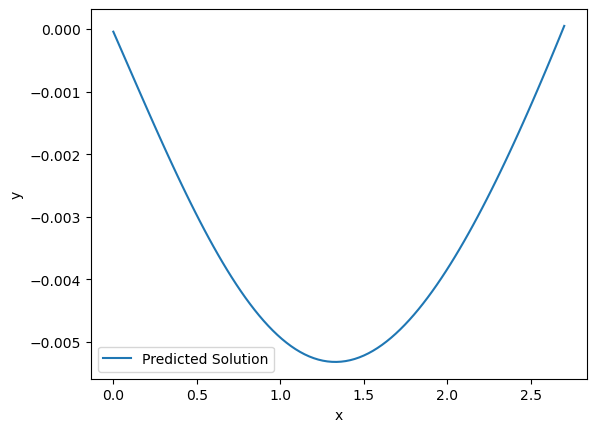

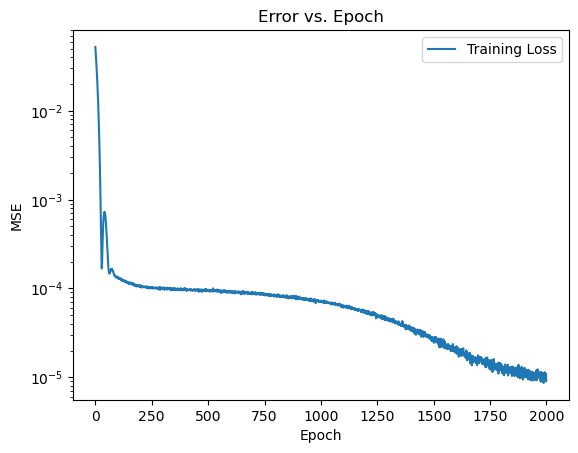

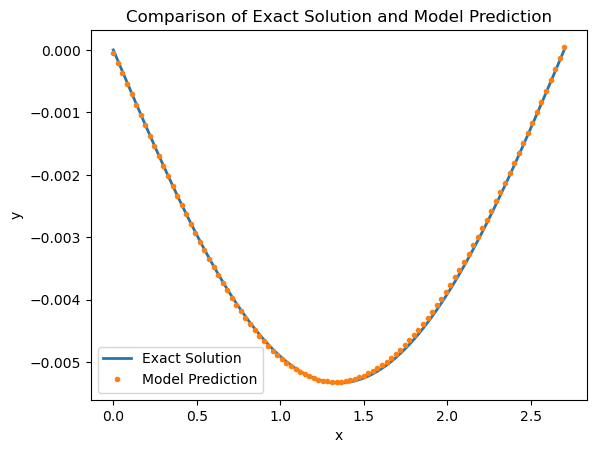

In [6]:
# y vs x graph
x_test = tf.linspace(0.0, L, 100)[:, None]
y_pred = model(x_test)

plt.plot(x_test.numpy(), y_pred.numpy(), label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Error vs epoch graph
# loss_history = [item[0][0] for item in loss_history]
plt.semilogy(range(epochs), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Error vs. Epoch')
plt.legend()
plt.show()

# exact solution vs. prediction graph
y_exact = w * ((2*L*x_test**3) - (x_test*L**3) - x_test**4) / (24 * E * I)
plt.plot(x_test, y_exact, label='Exact Solution', linewidth=2)
plt.plot(x_test, y_pred, 'o', label='Model Prediction', markersize=3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Exact Solution and Model Prediction') 
plt.legend()
plt.show()